In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix

In [7]:
base_dir = r"E:\healthai\data\images\chest_xray"

train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
val_dir = os.path.join(base_dir, "val")

print("Train classes:", os.listdir(train_dir))


Train classes: ['NORMAL', 'PNEUMONIA']


In [8]:
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [9]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))
print("Classes:", train_dataset.classes)


Train size: 5216
Test size: 624
Classes: ['NORMAL', 'PNEUMONIA']


In [10]:
class ChestCNN(nn.Module):
    def __init__(self):
        super(ChestCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 12 * 12, 128),  # 96x96 input → 12x12 after pooling
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.squeeze()

model = ChestCNN()

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

print("Model initialized.")


Model initialized.


In [11]:
epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        labels = labels.float()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/5] Loss: 0.2440
Epoch [2/5] Loss: 0.1344
Epoch [3/5] Loss: 0.1003
Epoch [4/5] Loss: 0.0908
Epoch [5/5] Loss: 0.0759


In [12]:
model.eval()

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)

        probs = outputs.numpy()
        threshold = 0.9
        preds = (probs > threshold).astype(int)


        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs)

print("Test Accuracy:", round(accuracy, 4))
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("ROC-AUC:", round(auc, 4))

Test Accuracy: 0.8446
Precision: 0.811
Recall: 0.9795
ROC-AUC: 0.9405


In [13]:
unique, counts = np.unique(all_preds, return_counts=True)

print("\nPrediction Distribution:")
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} predictions")



Prediction Distribution:
Class 0: 153 predictions
Class 1: 471 predictions


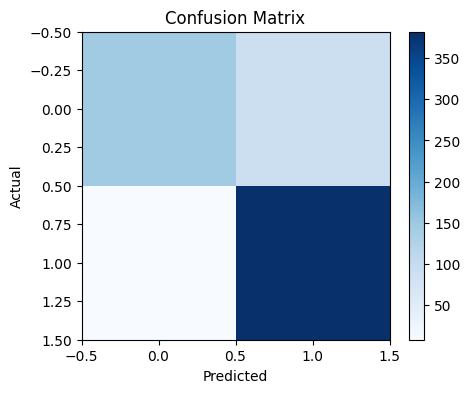

In [14]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [15]:
os.makedirs("../models/imaging", exist_ok=True)
torch.save(model.state_dict(), "../models/imaging/chest_cnn_model.pth")

print("CNN model saved successfully.")


CNN model saved successfully.
